### **0. Setup**

In [1]:
import os, glob, warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family': 'Arial', 'size': 15}
mpl.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'
my_pal = ['grey', 'mediumseagreen']

# Make a folder if it not there yet and if needed
# !mkdir ../jupyter_figures

# set the directory where the data files are waiting
directory = '/Users/ShokenLEE/Desktop/n/P-169/Output_from_IJMacro/StarDist/'

### **1. Concanatate all the CSV files**

In [2]:
df = pd.DataFrame()

filepaths = os.listdir(directory)
for filepath in filepaths:
    if filepath.endswith('csv'):
        _df = pd.read_csv(directory + '/' + filepath)
        df = pd.concat([df, _df], axis=0)

In [3]:
df.head()

,,Area,Mean,Circ.,AR,Round,Solidity,DNA mean,Tag mean,File name
0,1,258.733,5051.392,0.850,1.930,0.518,1.001,6250.404,7466.657,11-12-21 U2OSKO Flg-lpn1 DE 488Flg 561Sun2 t3-...
1,2,257.578,3889.256,0.979,1.203,0.831,0.999,5382.987,2557.746,11-12-21 U2OSKO Flg-lpn1 DE 488Flg 561Sun2 t3-...
2,3,237.977,4199.769,0.870,1.076,0.930,0.970,5638.359,2652.321,11-12-21 U2OSKO Flg-lpn1 DE 488Flg 561Sun2 t3-...
3,4,131.747,5043.999,0.873,1.162,0.860,0.924,7476.785,2975.285,11-12-21 U2OSKO Flg-lpn1 DE 488Flg 561Sun2 t3-...
4,5,137.942,4720.209,0.737,1.169,0.855,0.930,5348.517,2501.948,11-12-21 U2OSKO Flg-lpn1 DE 488Flg 561Sun2 t3-...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 22
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0              1016 non-null   int64  
 1   Area       1016 non-null   float64
 2   Mean       1016 non-null   float64
 3   Circ.      1016 non-null   float64
 4   AR         1016 non-null   float64
 5   Round      1016 non-null   float64
 6   Solidity   1016 non-null   float64
 7   DNA mean   1016 non-null   float64
 8   Tag mean   1016 non-null   float64
 9   File name  1016 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 87.3+ KB


#### Check the number of files

In [5]:
files = df['File name'].unique()
print(len(files))

59


### **2. Add columns**

####  **Cell_type**

In [6]:
df.loc[df['File name'].str.contains('ctrl'), 'Cell type'] = 'Control'
df.loc[df['File name'].str.contains('KO'), 'Cell type'] = 'CTDNEP1 KO'

#### **Plasmid type**

In [7]:
df.loc[df['File name'].str.contains('WT'), 'Plasmid type'] = 'WT'
df.loc[df['File name'].str.contains('DE'), 'Plasmid type'] = 'DE'

#### **Image number**

In [8]:
df['Image number'] = df['File name'].str[-7:-4]

##### Check the number is correctly extracted

In [9]:
print(list(df['Image number'].unique())[1])

002


#### **Tag expression**

##### **Check Tag intensity**

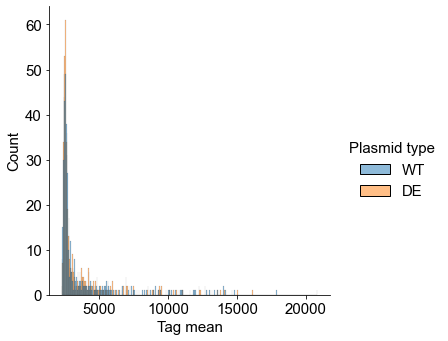

In [10]:
hist = sns.displot(data=df, x='Tag mean', hue='Plasmid type', hue_order=['WT', 'DE'], binwidth=50)
# plt.xlim([1000,4000])

(1000.0, 4000.0)

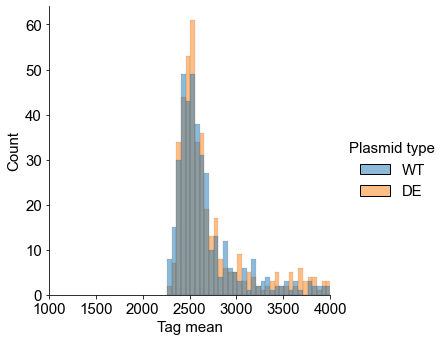

In [11]:
hist = sns.displot(data=df, x='Tag mean', hue='Plasmid type', hue_order=['WT', 'DE'], binwidth=50)
plt.xlim([1000,4000])

##### ***Set the threshold***

In [12]:
min_tag_intensity = 3200

In [13]:
df.loc[df['Tag mean'] > min_tag_intensity, 'Tag expression'] = '(+)'
df.loc[df['Tag mean'] <= min_tag_intensity, 'Tag expression'] = '(-)'

#### **C3 channel intensity**

##### **C3 distribution**

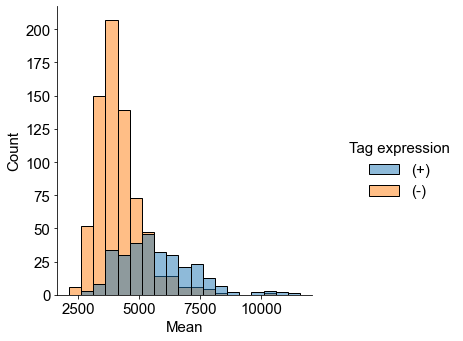

In [14]:
hist = sns.displot(x='Mean', data=df, hue='Tag expression', binwidth=500)

In [15]:
df.groupby('Tag expression')['Mean'].min()

Tag expression
(+)    3015.276
(-)    2113.495
Name: Mean, dtype: float64

##### ***Set the background intensity***

In [16]:
background_C3 = 2000

In [17]:
df['C3 mean - background'] = df['Mean']-background_C3

#### **Normalized C3 channel intensity**

##### **Get the mean intensity of plasmid (-) cells**

In [18]:
C3_mean_of_non_tfx_cells = np.mean(df[df['Tag expression']=='(-)']['C3 mean - background'])

In [19]:
df['C3-Back_normalized'] = df['C3 mean - background']/C3_mean_of_non_tfx_cells

#### **ROI number**

In [20]:
df = df.rename(columns={' ': 'ROI number'})

#### **Sample type (for Tukey test)**

In [21]:
# specify what columns are joined to name 'Sample_type'
sampletype_columns = ['Cell type', 'Plasmid type', 'Tag expression']
df['Sample_type'] = df[sampletype_columns].agg('_'.join, axis=1)

### **3. Exclude mitotic cells, which show higher DNA intensity**

##### **Check DNA intensity**

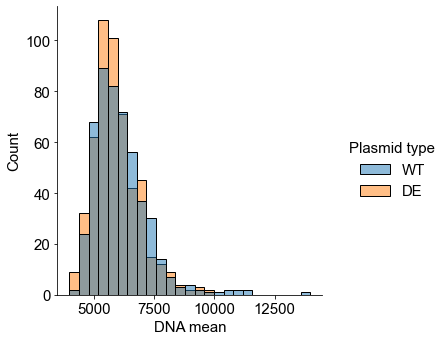

In [22]:
hist = sns.displot(data=df, x='DNA mean', hue='Plasmid type', hue_order=['WT', 'DE'], binwidth=400)
# plt.xlim([1000,4000])

##### **Set the threshold**

In [23]:
max_DNA_intensity = 9000

In [24]:
df = df[df['DNA mean'] < max_DNA_intensity]

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 22
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ROI number            998 non-null    int64  
 1   Area                  998 non-null    float64
 2   Mean                  998 non-null    float64
 3   Circ.                 998 non-null    float64
 4   AR                    998 non-null    float64
 5   Round                 998 non-null    float64
 6   Solidity              998 non-null    float64
 7   DNA mean              998 non-null    float64
 8   Tag mean              998 non-null    float64
 9   File name             998 non-null    object 
 10  Cell type             998 non-null    object 
 11  Plasmid type          998 non-null    object 
 12  Image number          998 non-null    object 
 13  Tag expression        998 non-null    object 
 14  C3 mean - background  998 non-null    float64
 15  C3-Back_normalized    99

### **Optional: Filter by ROI area if needed**

#### Should be done only when fused multiple nuclei would be problematic

In [26]:
min_area_of_roi = 60
# max_area_of_roi = 200
df = df[(df['Area'] > min_area_of_roi)]

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779 entries, 0 to 19
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ROI number            779 non-null    int64  
 1   Area                  779 non-null    float64
 2   Mean                  779 non-null    float64
 3   Circ.                 779 non-null    float64
 4   AR                    779 non-null    float64
 5   Round                 779 non-null    float64
 6   Solidity              779 non-null    float64
 7   DNA mean              779 non-null    float64
 8   Tag mean              779 non-null    float64
 9   File name             779 non-null    object 
 10  Cell type             779 non-null    object 
 11  Plasmid type          779 non-null    object 
 12  Image number          779 non-null    object 
 13  Tag expression        779 non-null    object 
 14  C3 mean - background  779 non-null    float64
 15  C3-Back_normalized    77

### **4. Inspect the data**

#### **4-1. Check cell counts per sample**

Text(0.5, 1.0, 'Number of cells')

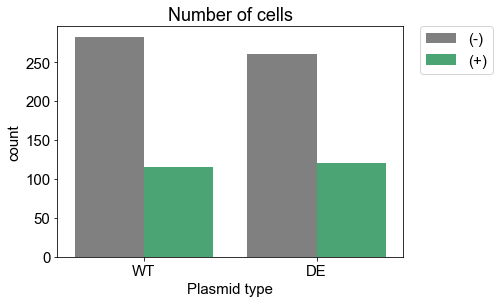

In [28]:
# fig_width, fig_height = 3.0, 3.0
# fig = plt.figure(figsize=(fig_width,fig_height))
fig = plt.figure()
ax_count = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# ax_count = sns.countplot(data=df, x='Sample_type')
ax_count = sns.countplot(data=df, x='Plasmid type', order=['WT', 'DE'], hue='Tag expression', hue_order=['(-)', '(+)'], palette=my_pal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Number of cells')
# ax_count.set_xticklabels(labels=samples_order, rotation=45, ha='right')

In [29]:
df.groupby(['Plasmid type', 'Tag expression']).size()

Plasmid type  Tag expression
DE            (+)               121
              (-)               261
WT            (+)               115
              (-)               282
dtype: int64

#### **4-3. C3 channel normalized intensity**

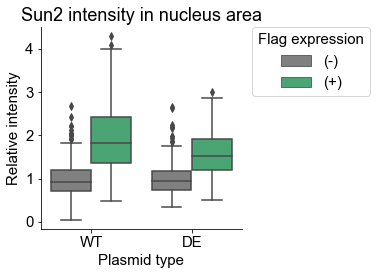

In [30]:
fig = plt.figure(figsize=(3.5,3.5))
ax_count = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax_box = sns.boxplot(data=df, x='Plasmid type', y='C3-Back_normalized', order=['WT', 'DE'], hue='Tag expression', hue_order=['(-)', '(+)'], palette=my_pal)
plt.legend(title='Flag expression', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Sun2 intensity in nucleus area')
plt.ylabel('Relative intensity')
ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)

In [31]:
fig.savefig(directory + '/C3_intensity.jpg', bbox_inches='tight')

#### **Scatter plot (Tag vs C3)**

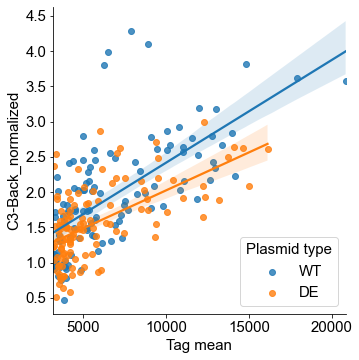

In [32]:
scatter = sns.lmplot(x='Tag mean', y='C3-Back_normalized', data=df[df['Tag expression']=='(+)'], hue='Plasmid type', hue_order=['WT', 'DE'], legend_out=False)

In [33]:
scatter.savefig(directory + '/Tag_vs_C3.jpg', bbox_inches='tight')

#### **4-4. Tukey test**

In [34]:
res = pairwise_tukeyhsd(df['C3-Back_normalized'], df['Sample_type'], alpha=0.05)

In [35]:
print(res)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1            group2      meandiff p-adj  lower   upper  reject
-------------------------------------------------------------------------
CTDNEP1 KO_DE_(+) CTDNEP1 KO_DE_(-)  -0.5688 0.001  -0.708 -0.4295   True
CTDNEP1 KO_DE_(+) CTDNEP1 KO_WT_(+)    0.374 0.001  0.2091  0.5389   True
CTDNEP1 KO_DE_(+) CTDNEP1 KO_WT_(-)  -0.5788 0.001 -0.7164 -0.4412   True
CTDNEP1 KO_DE_(-) CTDNEP1 KO_WT_(+)   0.9428 0.001  0.8011  1.0845   True
CTDNEP1 KO_DE_(-) CTDNEP1 KO_WT_(-)    -0.01   0.9 -0.1188  0.0987  False
CTDNEP1 KO_WT_(+) CTDNEP1 KO_WT_(-)  -0.9528 0.001 -1.0929 -0.8127   True
-------------------------------------------------------------------------


### **5. Export the C3-Back_normalized by plasmid types**

In [36]:
df_export = df[['Plasmid type', 'Tag expression','C3-Back_normalized']]

In [37]:
df_export.head()

,Plasmid type,Tag expression,C3-Back_normalized
0,DE,(+),1.422613
1,DE,(-),0.880805
2,DE,(-),1.025571
3,DE,(-),1.419166
4,DE,(-),1.268210


In [38]:
df_export['Expt_number'] = 'P-169'

In [39]:
df_export.to_csv('./P-169_export.csv', index=False)